In [1]:
import sys
import logging
import warnings
import itertools
import subprocess
from tqdm.auto import tqdm, trange
import argparse
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
import time
import pytorch_lightning as pl
import gc
from botorch.utils.transforms import normalize, unnormalize, standardize
import botorch

# My imports
from weighted_retraining.weighted_retraining.chem.chem_data import (
    WeightedJTNNDataset,
    WeightedMolTreeFolder,
    Vocab, 
)
from weighted_retraining.weighted_retraining.chem.jtnn.datautils import tensorize

from weighted_retraining.weighted_retraining.chem.chem_data import tensorize as tensorize_smiles
from weighted_retraining.weighted_retraining.chem.chem_data import  get_vocab_from_tree

from weighted_retraining.weighted_retraining.chem.chem_model import JTVAE
from weighted_retraining.weighted_retraining import utils
from weighted_retraining.weighted_retraining.chem.chem_utils import rdkit_quiet, standardize_smiles
from weighted_retraining.weighted_retraining.chem.jtnn.mol_tree import MolTree
from property_predictor import train_model, predict_activity
from bayes_opt_loop import GPModel, fit_gp_model
# from weighted_retraining.weighted_retraining.opt_scripts import base as wr_base

/home/hueyhoang/anaconda3/envs/env_ecen689/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Extra Arguments
rdkit_quiet()

tkwargs = {
    "dtype": torch.float,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [3]:
def _encode_mol_trees(model, mol_trees):
    batch_size = 64
    mu_list = []
    with torch.no_grad():
        for i in trange(
            0, len(mol_trees), batch_size, desc="encoding mol trees", leave=False
        ):
            batch_slice = slice(i, i + batch_size)
            _, jtenc_holder, mpn_holder = tensorize(
                mol_trees[batch_slice], model.jtnn_vae.vocab, assm=False
            )
            tree_vecs, _, mol_vecs = model.jtnn_vae.encode(jtenc_holder, mpn_holder)
            muT = model.jtnn_vae.T_mean(tree_vecs)
            muG = model.jtnn_vae.G_mean(mol_vecs)
            mu = torch.cat([muT, muG], axis=-1).cpu().numpy()
            mu_list.append(mu)

    # Aggregate array
    mu = np.concatenate(mu_list, axis=0).astype(np.float64)
    return mu

def encode_smiles(model, list_smiles, vocab_set):
    seed_mol_trees = []
    for s in list_smiles:
        if s is None:
            continue

        s_std = standardize_smiles(s)
        
        if s_std is None:
            continue
            
        tree_tensor = tensorize_smiles(s_std)

        # Make sure satisfies vocab check
        v_set = get_vocab_from_tree(tree_tensor)

        if v_set <= vocab_set:
            seed_mol_trees.append(tree_tensor)
        else:
            print("the given smiles did not match with vocab of JT-VAE")
            continue

    seed_latent_points = _encode_mol_trees(model, seed_mol_trees)

    return seed_latent_points


def _batch_decode_z_wo_props(
    model,
    z,
):
    """
    helper function to decode some latent vectors 
    """


    # Decode all points in a fixed decoding radius
    z_decode = []
    batch_size = 64
    for j in range(0, len(z), batch_size):
        with torch.no_grad():
            z_batch = z[j : j + batch_size]
            smiles_out = model.decode_deterministic(z_batch.to(**tkwargs))
            
        z_decode += smiles_out

    return z_decode

def sample_smiles(model, seed_latent_points, sample_freq = 5, sigma = 0.1):
    new_z = []

    for z in seed_latent_points:
        new_z.append(np.random.normal(z, sigma, size=(sample_freq, len(z))))

    new_z = np.vstack(new_z)
    new_z = np.unique(new_z, axis = 0)

    new_z = torch.tensor(new_z)

    cands_smiles = _batch_decode_z_wo_props(model, new_z)
    unique_cands_smiles = list(set(cands_smiles))
    print(f"removed {len(cands_smiles)-len(unique_cands_smiles)} repeated smiles")

    return unique_cands_smiles

def find_valid(list_smiles, list_labels, vocab_set):
    valid_smiles = []
    valid_labels = []
    for idx, s in tqdm(enumerate(list_smiles)):
        try:
            if s is None:
                continue

            s_std = standardize_smiles(s)

            if s_std is None:
                continue

            tree_tensor = tensorize_smiles(s_std)

            # Make sure satisfies vocab check
            v_set = get_vocab_from_tree(tree_tensor)

            if v_set <= vocab_set:
                valid_smiles.append(s)
                valid_labels.append(list_labels[idx])
            else:
                continue
        except Exception as e:
            pass

    return valid_smiles, valid_labels


In [4]:
print("Seeding")
# Seeding
pl.seed_everything(42)

# print("Make results directory")
# # Make results directory
# result_dir = Path(args.result_root).resolve()
# result_dir.mkdir(parents=True)

with open("./weighted_retraining/data/vocab.txt") as f:
    vocab = Vocab([x.strip() for x in f.readlines()])

# Load model
model = JTVAE.load_from_checkpoint(
    "./weighted_retraining/assets/pretrained_models/chem_vanilla/chem.ckpt", vocab= vocab
)
model.beta = model.hparams.beta_final  # Override any beta annealing
model = model.cuda()

model.eval()

Seeding


JTVAE(
  (jtnn_vae): JTNNVAE(
    (jtnn): JTNNEncoder(
      (embedding): Embedding(780, 450)
      (outputNN): Sequential(
        (0): Linear(in_features=900, out_features=450, bias=True)
        (1): ReLU()
      )
      (GRU): GraphGRU(
        (W_z): Linear(in_features=900, out_features=450, bias=True)
        (W_r): Linear(in_features=450, out_features=450, bias=False)
        (U_r): Linear(in_features=450, out_features=450, bias=True)
        (W_h): Linear(in_features=900, out_features=450, bias=True)
      )
    )
    (decoder): JTNNDecoder(
      (embedding): Embedding(780, 450)
      (W_z): Linear(in_features=900, out_features=450, bias=True)
      (U_r): Linear(in_features=450, out_features=450, bias=False)
      (W_r): Linear(in_features=450, out_features=450, bias=True)
      (W_h): Linear(in_features=900, out_features=450, bias=True)
      (W): Linear(in_features=478, out_features=450, bias=True)
      (U): Linear(in_features=478, out_features=450, bias=True)
      (U_i):

In [5]:
df = pd.read_csv('data.csv')
smiles = df['SMILES'].to_numpy()
activity = df['LABEL'].to_numpy()


indices = np.random.choice(len(smiles), 500, replace=False)
short_smiles = smiles[indices]
short_activity = activity[indices]

In [6]:
valid_smiles, valid_labels = find_valid(list_smiles = smiles,
                                        list_labels = activity,
                                        vocab_set = set(vocab.vocab))

0it [00:00, ?it/s]

26640it [18:22:23,  2.48s/it]


In [7]:
seed_latent_points = encode_smiles(model, valid_smiles, set(vocab.vocab))

In [11]:
def bayes_opt(num_queries, train_x, train_y, normal_bounds, JTVAE, pp_model, gp_epoch):
    
    normalize_train_x = normalize(torch.tensor(train_x, dtype=(torch.float)), normal_bounds)
    standardize_train_y = standardize(torch.tensor(train_y, dtype=torch.float))

    train_y = torch.tensor(train_y)

    iteration = []
    new_x = []
    new_y = []


    for i in tqdm(range(num_queries)):
        # print("incumbent:", normalize_train_x[standardize_train_y.argmax()], standardize_train_y.max())
    
        model, likelihood = fit_gp_model(normalize_train_x, standardize_train_y, gp_epoch)
        policy = botorch.acquisition.analytic.ExpectedImprovement(model, best_f = standardize_train_y.max())

        lower_bounds = torch.zeros(train_x.shape[1]) 
        upper_bounds = torch.ones(train_x.shape[1])   
        bounds = torch.stack([lower_bounds, upper_bounds])

        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds = bounds,
            q = 1,
            num_restarts=10,
            raw_samples=20,
        )

        unnormalize_next_x = unnormalize(next_x, normal_bounds)

        # train_x.append(unnormalize_next_x)

        decoded_x = _batch_decode_z_wo_props(JTVAE, unnormalize_next_x)


        next_y = predict_activity(pp_model, decoded_x[0])

        next_y = torch.tensor(next_y)

        # train_y.append(next_y)

        # next_y = [] #Unnormalize --> Send next_x to decoder  --> Property Predictor

        normalize_train_x = torch.cat([normalize_train_x, next_x])
        train_y = torch.cat([train_y, next_y]) # Concat to raw data then standardize before concatonation
        new_standardize_train_y = standardize(torch.tensor(train_y))
        standardize_train_y = new_standardize_train_y

        iteration.append(i)
        new_x.append(unnormalize_next_x)
        new_y.append(next_y)

    return iteration, new_x, new_y


Drug Property Prediction Mode...
in total: 26640 drugs
encoding drug...
unique drugs: 13764
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 356.570. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 121.387. Total time 0.00305 hours
Validation at Epoch 1 , MSE: 164.244 , Pearson Correlation: 0.63216 with p-value: 2.87E-297 , Concordance Index: 0.69991
Training at Epoch 2 iteration 0 with loss 181.145. Total time 0.00472 hours
Training at Epoch 2 iteration 100 with loss 66.9796. Total time 0.00777 hours
Validation at Epoch 2 , MSE: 72.5057 , Pearson Correlation: 0.84770 with p-value: 0.00E+00 , Concordance Index: 0.77758
Training at Epoch 3 iteration 0 with loss 64.5238. Total time 0.00972 hours
Training at Epoch 3 iteration 100 with loss 53.2721. Total time 0.01333 hours
Validation at Epoch 3 , MSE: 29.3576 , Pearson Correlation: 0.94035 with p-value: 0.00E+00 , Concordance Index: 0.84396
Training at Epoch

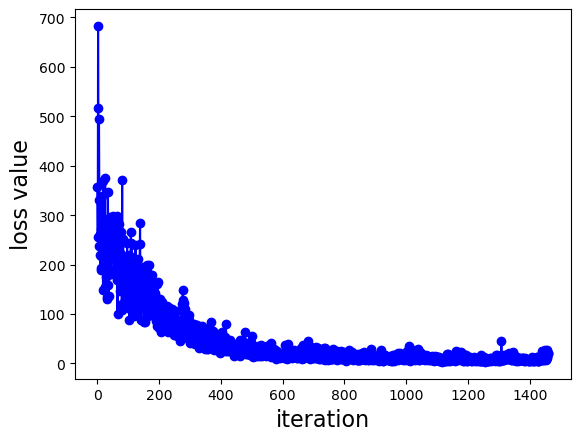

In [9]:
pp_model = train_model(smiles = smiles, 
                       activity = activity)

In [10]:
normal_bounds = torch.tensor([[0.0] * seed_latent_points.shape[1], [1.0] * seed_latent_points.shape[1]])

In [ ]:
iteration ,X_list, y_list = bayes_opt(num_queries=100,
                           train_x = seed_latent_points,
                           train_y = valid_labels,
                           normal_bounds = normal_bounds,
                           JTVAE = model,
                           pp_model = pp_model,
                           gp_epoch=500)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
mol = []

for x in X_list:
    mol.append(_batch_decode_z_wo_props(model, x))

In [ ]:
y_list_new = []

for y in y_list:
    y_list_new.append(y.item())

In [23]:
len(mol), len(y_list_new)

(1000, 1000)

In [17]:
df = pd.DataFrame(data = {'Iteration': iteration, 'Drug': mol, 'Activity': y_list_new})

df.sort_values(by = 'Activity', ascending = False).head()

,Iteration,Drug,Activity
839,839,[CC(=O)NCc1ccccc1C(=O)N1CCC2CCC([NH3+])(C1)[NH...,16.339813
316,316,[CC1C[NH2+]CC([NH3+])(C(=O)Nc2nnc(-c3cccc4c3OC...,16.311773
47,47,[Cc1occc1CN1CCC(C)(C(=O)Nc2cccc3ccccc23)CC1=O],16.229059
175,175,[Cc1noc(-c2cccc(NC(=O)C3CC4(C)CCC3C4)c2)n1],15.395352
205,205,[Cc1noc(-c2cccc(NC(=O)C3CC4(C)CCC3C4)c2)n1],15.395352


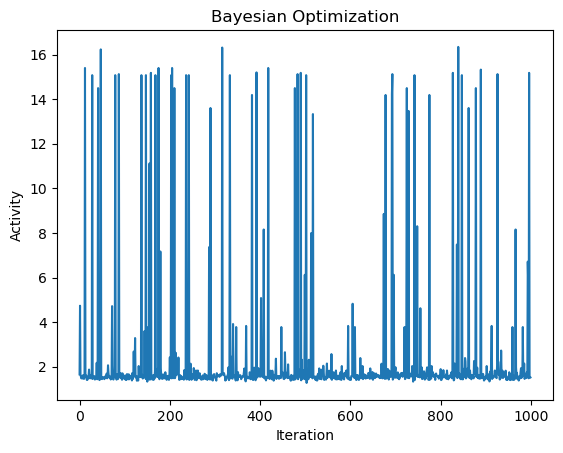

In [18]:
import matplotlib.pyplot as plt

plt.plot(iteration, y_list_new)
plt.xlabel('Iteration')
plt.ylabel('Activity')
plt.title('Bayesian Optimization')
plt.show()

In [22]:
# Check valid smiles
from rdkit import Chem
count = 0


for i in mol:
    m = Chem.MolFromSmiles(i[0])
    if m:
        continue
    else:
        count += 1

count

0

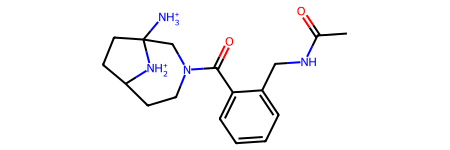

In [21]:
Chem.MolFromSmiles(mol[839][0])